In [1]:
using DelimitedFiles
using Arpack
using LinearAlgebra
using Statistics
using Base.Threads
using Random
using Plots
using SparseArrays
using ProgressMeter

"""
Ising model Monte-Carlo simulation on a dense graph
H = -J/N * sum_{i,j} W_{ij} S_i S_j
"""
mutable struct IsingModel
    N::Int
    J::Float64
    W::Matrix{Float64}
    spins::Vector{Int}
    temperature::Float64
end

"""
Calculate the energy of the current spin configuration
"""
function calculate_energy(model::IsingModel)
    return -model.J / model.N * dot(model.spins, model.W, model.spins)
end

"""
Calculate the magnetization of the current spin configuration
"""
function calculate_magnetization(model::IsingModel)
    return sum(model.spins) / model.N
end

"""
Calculate the local field at site i
"""
function local_field(model::IsingModel, i::Int)
    s = 0.0
    @inbounds @simd for j in 1:model.N
        s += model.W[i, j] * model.spins[j]
    end
    # Subtract self-interaction if W[i,i] != 0
    return model.J / model.N * (s - model.W[i, i] * model.spins[i])
end

"""
Perform one Monte-Carlo step using Metropolis algorithm
"""
# function monte_carlo_step!(model::IsingModel)
#     N = model.N
#     β = 1.0 / model.temperature
    
#     # Pick ONE random spin to potentially flip
#     i = rand(1:N)
#     spin_i = model.spins[i]
#     ΔE = 2.0 * spin_i * local_field(model, i)
    
#     if ΔE <= 0 || rand() < exp(-β * ΔE)
#         model.spins[i] = -spin_i
#     end
# end


# function monte_carlo_step!(model::IsingModel)
#     N = model.N
#     β = 1.0 / model.temperature
    
#     @inbounds for _ in 1:N
#         i = rand(1:N)
#         spin_i = model.spins[i]
#         ΔE = 2.0 * spin_i * local_field(model, i)
        
#         if ΔE <= 0 || rand() < exp(-β * ΔE)
#             model.spins[i] = -spin_i
#         end
#     end
# end

function monte_carlo_step!(model::IsingModel)
    N = model.N
    β = 1.0 / model.temperature
    
    # Process spins in random order without replacement
    order = randperm(N)
    
    for i in order
        spin_i = model.spins[i]
        ΔE = 2.0 * spin_i * local_field(model, i)  # Note: need spin_i factor here!
        
        if ΔE <= 0 || rand() < exp(-β * ΔE)
            model.spins[i] = -spin_i
            # If local_field is expensive, update affected fields here
        end
    end
end

"""
Run Monte-Carlo simulation for a single temperature
"""
function run_simulation_single_temp(N::Int, J::Float64, W::Matrix{Float64}, 
                                  temperature::Float64, n_thermalization::Int, 
                                  n_measurement::Int, initial_spins::Vector{Int}=Int[])
    # Use provided initial spins or random ones
    if isempty(initial_spins)
        initial_spins = rand([-1, 1], N)
    end
    
    model = IsingModel(N, J, W, copy(initial_spins), temperature)
    
    # Thermalization
    for step in 1:n_thermalization
        monte_carlo_step!(model)
    end
    
    # Accumulate averaged spin configuration
    N = model.N
    averaged_spins = zeros(Float64, N)
    magnetization_series = zeros(n_measurement)
    
    for step in 1:n_measurement
        averaged_spins .+= float.(model.spins)
        magnetization_series[step] = abs(calculate_magnetization(model))
        monte_carlo_step!(model)
    end
    
    # Normalize to get the average spin configuration
    averaged_spins ./= n_measurement
    avg_magnetization = mean(magnetization_series)
    
    # Return the AVERAGED configuration, not a single snapshot
    return averaged_spins, avg_magnetization
end

"""
Parallel Monte-Carlo simulation for multiple temperatures
"""
function parallel_mc_simulation(N::Int, J::Float64, W::Matrix{Float64},
                              temperatures::Vector{Float64},
                              n_thermalization::Int = 1000,
                              n_measurement::Int = 1000,
                              initial_spins::Vector{Int} = Int[])
    
    n_temps = length(temperatures)
    all_spins = Vector{Vector{Float64}}(undef, n_temps)
    magnetizations = Vector{Float64}(undef, n_temps)
    
    if isempty(initial_spins)
        initial_spins = rand([-1, 1], N)
    end
    
    progress = Progress(n_temps, desc="Simulating temperatures...")
    
    @threads for idx in 1:n_temps
        current_initial_spins = isempty(initial_spins) ? Int[] : copy(initial_spins)
        spins, mag = run_simulation_single_temp(N, J, W, temperatures[idx], 
                                              n_thermalization, n_measurement, initial_spins)
        all_spins[idx] = spins
        magnetizations[idx] = mag
        next!(progress)
    end
    
    return all_spins, magnetizations
end

function create_erdos_renyi_graph(N::Int, p::Float64)
    # Create adjacency matrix for Erdős–Rényi graph
    A = zeros(N, N)
    for i in 1:N
        for j in (i+1):N
            if rand() < p
                A[i, j] = 1.0
                A[j, i] = 1.0
            end
        end
    end
    return A
end

function sw_graphon(N, p, r)
    dx = 1.0/N
    x = collect(1:N)*dx.-dx/2

    W = zeros(Float64,N,N);
    for i in 1:N
        for j in 1:N
            if (abs(x[i]-x[j])<r) | (abs(x[i]-x[j])>1-r)
                W[i,j] = (1-p)
            else
                W[i,j] = p
            end
        end
    end
    return W
end

sw_graphon (generic function with 1 method)

In [2]:
function estimate_free_energy_time_evolution(W::Matrix{Float64}, J::Float64, temperature::Float64, 
                                           initial_spins::Vector{Int}, n_steps::Int=10000)
    N = length(initial_spins)
    model = IsingModel(N, J, W, copy(initial_spins), temperature)
    
    free_energies = Float64[]
    energies = Float64[]
    entropies_estimate = Float64[]
    
    # For free energy estimation, we need a reference or use thermodynamic integration
    # Here we'll compute a running estimate of F = ⟨E⟩ - T⟨S_estimate⟩
    
    energy_history = Float64[]
    
    for step in 1:n_steps
        monte_carlo_step!(model)
        current_energy = calculate_energy(model)
        push!(energy_history, current_energy)
        
        # Keep only recent history for running average (last 1000 steps)
        if length(energy_history) > 1000
            energy_history = energy_history[end-999:end]
        end
        
        if step > n_steps ÷ 10  # Start measuring after initial equilibration
            avg_energy = mean(energy_history)
            energy_variance = var(energy_history)
            
            # Estimate entropy from energy fluctuations
            # S ≈ S₀ + C_v/2, where C_v = variance/T²
            heat_capacity = energy_variance / (temperature^2)
            entropy_estimate = heat_capacity / 2  # Rough approximation
            
            # Free energy estimate: F ≈ U - TS
            free_energy_estimate = avg_energy - temperature * entropy_estimate
            
            push!(free_energies, free_energy_estimate)
            push!(energies, avg_energy)
            push!(entropies_estimate, entropy_estimate)
        end
    end
    
    return free_energies, energies, entropies_estimate
end

estimate_free_energy_time_evolution (generic function with 2 methods)

In [3]:
# Parameters
J = 1.0
N = 5000
r = 0.1
p = 0.05

W = sw_graphon(N, p, r);
eigvals_W, eigvecs_W =  eigs(W, nev=4, which=:LM, tol=1e-12);

# Simulation parameters

In [4]:
Tc1 = eigvals_W[1]/N;
# Tc2 = eigvals_W[2]/N;
# Tc3 = eigvals_W[4]/N
Tc1

0.22999913085707008

In [5]:
# all_W_eigs = eigvals(W)/N;
# negative_eig_W = all_W_eigs .< 0
# negative_W_eigs = all_W_eigs[negative_eig_W];

In [6]:
#Tc1_AFM = abs(minimum(negative_W_eigs))

In [7]:
#initial_spins = Int.(sign.(eigvecs_W[:,2]));
initial_spins = rand([-1, 1], N);

In [8]:
# Tc2
# n_thermalization = 200000;
# n_measurement = 100000;
# T_shift = 0.08

In [14]:
n_thermalization = 4000;
n_measurement = 1000;

In [15]:
spins, mags = run_simulation_single_temp(N, J, W, Tc1-0.05, n_thermalization, n_measurement, initial_spins);

In [16]:
mags

0.7344168000000001

In [17]:
# all_W_eigvecs = eigvecs(W);
# eigvec_AFM_Tc1 = all_W_eigvecs[:,1];

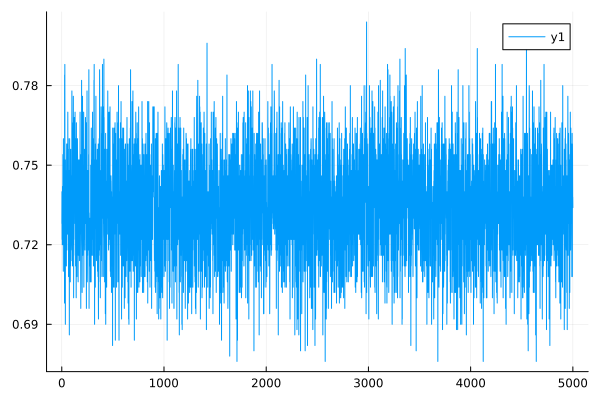

In [18]:
plot(spins)
#plot!(tanh.(eigvecs_W[:,4]*sqrt(N)))

In [19]:
writedlm("M-K_FM_Tc1_N_5000.csv",  spins, ',')

In [111]:
writedlm("M-K_FM_Tc2_N_10000.csv",  spins, ',')

In [112]:
#all_W_eigvecs = eigvecs(W);

In [113]:
#eigvec_AFM_Tc1 = all_W_eigvecs[:,1];

In [95]:
writedlm("FM_Tc3_eigvec.csv",  eigvecs_W[:,4], ',')

In [76]:
using DSP

In [77]:
function moving_average_dsp(data, window_size)
    # Create a moving average filter
    filt = ones(window_size) / window_size
    return filtfilt(filt, [1.0], data)
end

moving_average_dsp (generic function with 1 method)

In [78]:
test = moving_average_dsp(spins, 20);

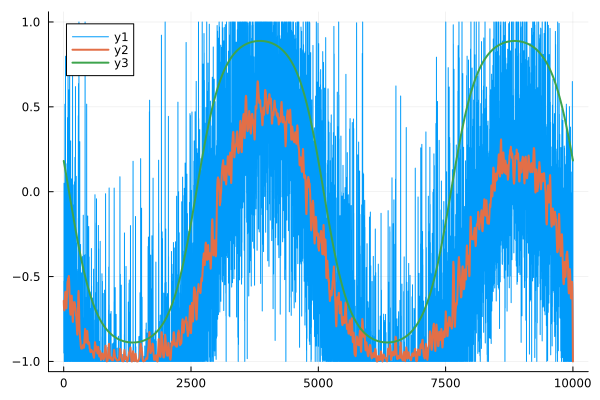

In [84]:
plot(spins)
plot!(test, width=2)
plot!(tanh.(eigvecs_W_N[:,4]*sqrt(N)), width=2)